# [Cloning my github repo to pull pre trained `U2NET`](https://github.com/deshwalmahesh/U-2-Net)

In [1]:
# ! git clone https://github.com/deshwalmahesh/U-2-Net
# %cd U-2-Net

# !wget -O ./data.tar.gz -q https://storage.googleapis.com/open_source_datasets/product_detection_from_packshots.tar.gz
# ! tar -xf ./data.tar.gz


# ! pip install onnxruntime
# ! pip install opencv-contrib-python==3.4.2.17
# # !pip install opencv-python==3.4.2.17

In [1]:
from U2Net.bg import * # import helpers, weights etc to remove background from the "Product Image", Download the quantized weights from drive

import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
from tqdm.notebook import tqdm

# Helpers

In [2]:
def resize(path, new_width_height = 480, convert_RGB = True):
    '''
    Resize and return Given Image
    args:
    path: Image Path
    new_width_height = Reshaped image's width and height. # If integer is given, it'll keep the aspect ratio as it is by shrinking the Bigger dimension (width or height) to the max of new_width_height  and then shring the smaller dimension accordingly 
    save_image = Whether to save the image or not
    convert_RGB: Whether to Convert the RGBA image to RGB (by default backgroud is white)
    '''
    image = Image.open(path)
    w, h = image.size

    if max(w,h) <= new_width_height: return None

    if h > w:
        fixed_height = new_width_height
        height_percent = (fixed_height / float(h))
        width_size = int((float(w) * float(height_percent)))
        image = image.resize((width_size, fixed_height), Image.Resampling.NEAREST)

    else:
        fixed_width = new_width_height
        width_percent = (fixed_width / float(w))
        height_size = int((float(h) * float(width_percent)))
        image = image.resize((fixed_width, height_size), Image.Resampling.NEAREST) # Try Image.ANTIALIAS inplace of Image.NEAREST


    if image.mode == "RGBA" and convert_RGB:
        new = Image.new("RGBA", image.size, "WHITE") # Create a white rgba background
        new.paste(image, (0, 0), image) # Paste the image on the background.
        image = new.convert('RGB')

    # image.format = "JPEG"
    # image.save(path, quality = 'keep', subsampling = 0)
    return image


def build_RGBA_image(img, mask):
    empty = Image.new("RGBA", (img.size), (255, 255,255)) # create a new white image of original size
    return Image.composite(img, empty, mask) # Overlay


def post_process_mask(mask:np.ndarray)->np.ndarray:
    '''
    Post Process the mask for a smooth boundary by applying Morphological Operations
    https://www.sciencedirect.com/science/article/pii/S2352914821000757
    args:
        mask: Binary Numpy Mask
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel)
    mask = cv2.GaussianBlur(mask, (5,5), sigmaX = 1.5, sigmaY = 1.5, borderType = cv2.BORDER_DEFAULT) # Blur
    mask = np.where( mask < 127, 0, 255).astype(np.uint8) # convert again to binary
    return mask


def remove_background(img,post_process:Callable = None):
    '''
    Remove background using U2Net. Returns tuple of RGBA image and it's predicted mask
    '''
    mask = onnx_session.predict(img)[0]
    if post_process is not None:
        mask = Image.fromarray(post_process_mask(np.array(mask))) # Apply post processing to mask
    
    return build_RGBA_image(img, mask), mask


def get_cropped_image(rgba_image, mask, convert_to: 'RGB'):
    '''
    Get the cropped part of RGBA image (in RGB format) given it's mask 
    '''
    rgba_image = rgba_image.convert(convert_to)
    x,y,w,h = cv2.boundingRect(np.array(mask))
    return np.array(rgba_image)[y:y+h,x:x+w,:] if convert_to == 'RGB' else np.array(rgba_image)[y:y+h,x:x+w]


def crop_all_BB(image, BB, resize = (32,32)):
    '''
    Given an image and it's bounding boxes, crop all the patches from it
    '''
    if isinstance(image,str): image = Image.open(image)
    res = []
    for (x1,y1,x2,y2) in BB:
        res.append(np.array(image.crop((x1,y1,x2,y2)).resize(resize)))
    
    return np.array(res)

In [3]:
PATH = "../product_detection_from_packshots/"

product = [PATH+ "product_images/"+i for i in os.listdir(PATH+ "product_images")]
shelf = [PATH+ "shelf_images/"+i for i in os.listdir(PATH+ "shelf_images")]

# Pre-processing: `Product`

Remove Background to decrease Noise -> Resize -> Save  

In [3]:
# for path in product: # remove background and resize all products
#     image = resize(Image.open(path))
#     rgba_image, mask = remove_background(image, post_process = post_process_mask)
#     image = Image.fromarray(get_cropped_image(rgba_image, mask, convert_to="RGB"))
#     image.format = "JPEG"
#     image.save(path, quality = "keep", subsampling = 0)

# YOLOv5 Detections

In [1]:
import warnings
warnings.filterwarnings("ignore") # Sourcechange Warning

from detect_boxes import *
YOLO5 = YOLODet()
YOLO5.build_model("./yolo_weights.pt", imgsz=640)

## Detect `Shelf`

In [4]:
# detections = {}
# for path in tqdm(shelf):
#     image = cv2.imread(path)
    
#     result = YOLO5.detect(image, draw_bb = False, iou_thres=0.51, conf_thres=0.45)
#     if result is not None:
#         detections[path] = result[:,:4].astype(int).tolist()
#     else:
#         detections[path]  = []


# with open('detections.json', 'w') as f: json.dump(detections, f)

with open('./detections.json') as f: detections = json.load(f)

## `Get crops`
Get all Crops from the original image

In [10]:
all_crops = {}
for key in tqdm(detections):
    BB = detections[key]
    if len(BB):
        all_crops[key] = crop_all_BB(key, BB)
    else:
        all_crops[key] = None

# Numpy is not serializable and `tolist()` bkew memory. Better to do on the fly

  0%|          | 0/3153 [00:00<?, ?it/s]

# Similarity : `MobileNet`
Use the smallest pre trained model possible

In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from numpy.linalg import norm

model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling = None)


def extract_features(img, model):

    preprocessed_img = preprocess_input(img)
    features = model.predict(preprocessed_img) # shape is [Batch, 1,1,1024]
    features = features.squeeze((1,2)) # shape is [Batch, 1024]
    normalized_features = features / norm(features) # L-2 Normalize to keep embeddings in 
    return normalized_features

In [ ]:
feat = extract_features(all_crops["../product_detection_from_packshots/shelf_images/db974.jpg"], model)

# Demo

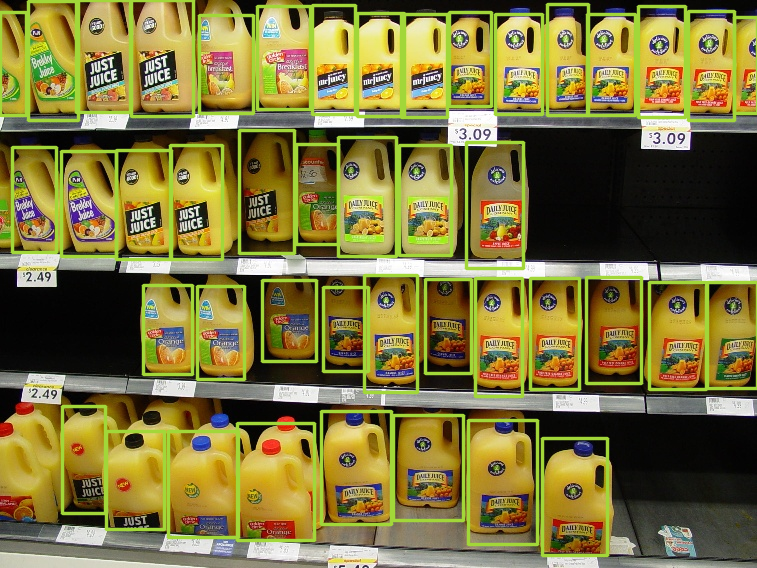

In [2]:
image = cv2.imread("../product_detection_from_packshots/shelf_images/db45.jpg")
result = YOLO5.detect(image, draw_bb = True, iou_thres=0.51, conf_thres=0.51)

if len(result.shape) == 3:
    result = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

result

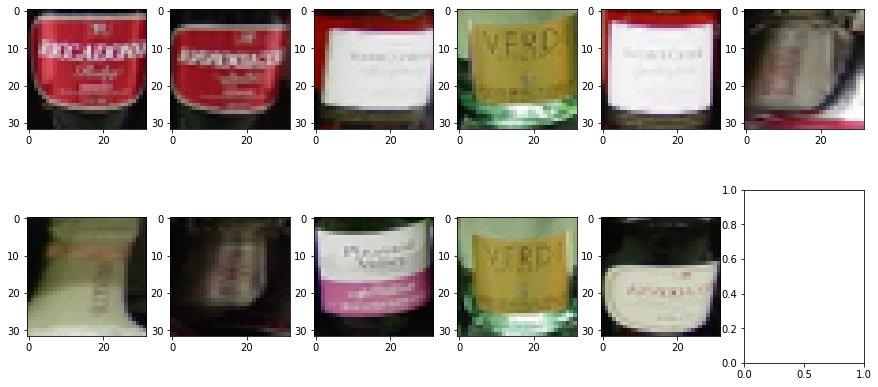

In [42]:
f, ax = plt.subplots(2,6, figsize = (15,7))
ax = ax.ravel()

for i, img in enumerate(all_crops["../product_detection_from_packshots/shelf_images/db974.jpg"]):
    ax[i].imshow(img)

In [1]:
from traditional_image_similarity import *

shel = cv2.imread("../product_detection_from_packshots/shelf_images/db974.jpg", 0)
pro = cv2.imread("../product_detection_from_packshots/product_images/qr80.jpg", 0)

Similarity = ImageSimilarity(Hessian_Threshold=500)
Similarity.method_list

['SIFT',
 'SURF',
 'ORB',
 'SSIM',
 'template_matching',
 'histogram_compare',
 'template_match_histograms',
 'scale_invariant_template_matching']

number of estimated clusters : 5
583
299
286
386
235


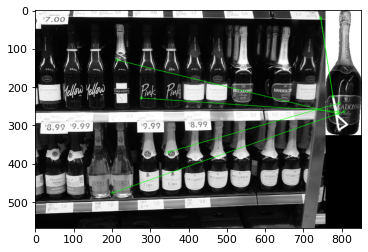

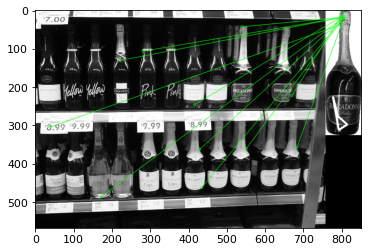

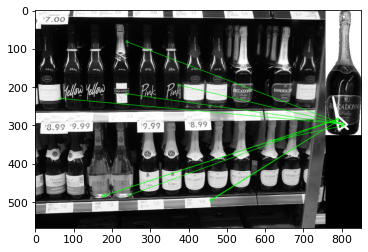

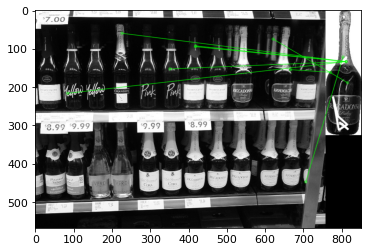

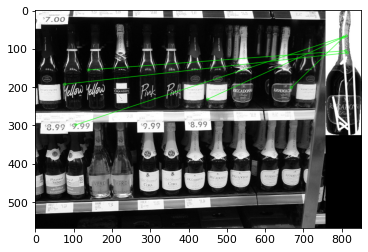

In [7]:
# score = Similarity.compare_images(shel,pro, method = 'SURF', **{'plot_image':True}) # available for Opencv 3.4 or lower

score = Similarity.compare_images(shel,pro, method = 'SIFT', **{'plot_image':False})

Similarity.compare_images(shel,pro, method = 'ORB', **{'plot_image':False})

score = Similarity.compare_images(shel,pro, method = 'histogram_compare', **{'compare_method':"Hellinger"}) 

score = Similarity.compare_images(shel,pro, method = 'template_match_histograms')

bb = Similarity.compare_images(shel,pro, method = 'template_matching', **{'plot_image':False}) # Gives you a Bounding Box with the plot

# bb = Similarity.scale_invariant_template_matching(shel,pro,show_live=False) Takes some time 

multi_obj_feature_matching(shel, pro, plot_live = True)